In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from tensorflow.keras.models import load_model
from data_utils import prepare_data, normalize_min_max_v2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def f1_metric(val_1, val2):
    if val_1 + val2 == 0:
        return 0  # To avoid division by zero
    return 2 * (val_1 * val2) / (val_1 + val2)

PATH = 'results/cnn1d_models'

tr_metrics = []
rt_metrics = []
combined_metrics = []
tr_names = []

2023-11-30 11:37:53.812564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-30 11:37:53.852063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:37:53.852399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.605GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-11-30 11:37:53.852585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-30 11:37:53.853851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 11:37:53.855128: I tensorflow/stream_executor

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4096, 8)           264       
_________________________________________________________________
activation_3 (Activation)    (None, 4096, 8)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2048, 8)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 16)          4112      
_________________________________________________________________
activation_4 (Activation)    (None, 2048, 16)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1024, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

2023-11-30 11:37:54.668106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-30 11:37:54.811915: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


test_acc 89.99999761581421
retest_acc 85.00000238418579
Test-Retest Model Metrics:
Accuracy: 89.99999761581421%
Precision: 0.8833333333333332
Recall: 0.9
F1 Score: 0.8766666666666667

Retest-Test Model Metrics:
Accuracy: 85.00000238418579%
Precision: 0.85
Recall: 0.85
F1 Score: 0.8233333333333335


/home/user/yahya/other/listener_cls_ffr/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/yahya/other/listener_cls_ffr/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


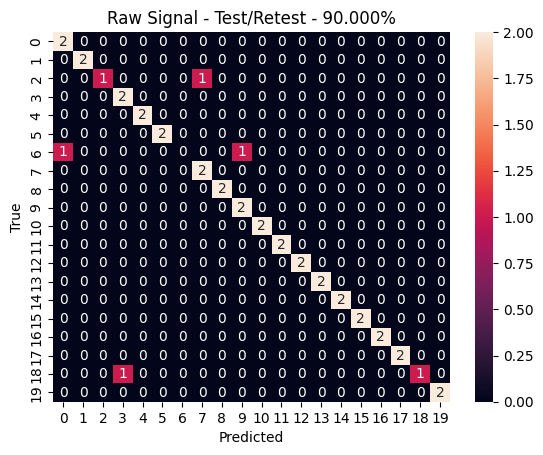

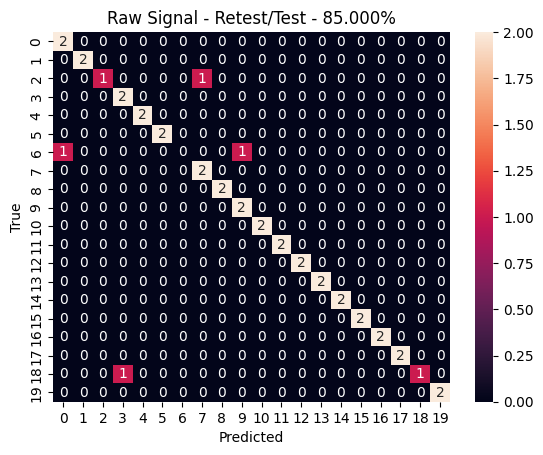

In [2]:

tr_exp = 'cnn1d_raw_test_retest'
rt_exp = 'cnn1d_raw_retest_test'
# Specify the path to the saved h5 model file
raw_test_retest_path = f'{PATH}/{tr_exp}.h5'
raw_retest_test_path = f'{PATH}/{rt_exp}.h5'

# Load the model
raw_test_retest_model = load_model(raw_test_retest_path)
raw_retest_test_model = load_model(raw_retest_test_path)

print(raw_retest_test_model.summary())

NPY_DATA_DIR = "npy_datasets"

# Load the dataset
test_dataset = np.load(
    f"{NPY_DATA_DIR}/test_aenu.npy", allow_pickle=True
)
retest_dataset = np.load(
    f"{NPY_DATA_DIR}/retest_aenu.npy", allow_pickle=True
)

X_test, y_test = prepare_data(test_dataset)
X_retest, y_retest = prepare_data(retest_dataset)

print(X_test.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_retest = X_retest.reshape(X_retest.shape[0], X_retest.shape[1], 1)

_, test_acc = raw_test_retest_model.evaluate(X_retest, y_retest, verbose=0)
_, retest_acc = raw_retest_test_model.evaluate(X_test, y_test, verbose=0)

test_acc = test_acc * 100
retest_acc = retest_acc * 100

tr_metrics.append(test_acc)
rt_metrics.append(retest_acc)
combined_metrics.append(f1_metric(test_acc, retest_acc))
tr_names.append('raw')

print('test_acc', test_acc)
print('retest_acc', retest_acc)

test_pred = raw_test_retest_model.predict(X_retest)
test_pred_classes = np.argmax(test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
test_confusion_mtx = confusion_matrix(y_test, test_pred_classes)

# Precision, recall, and F1 score for test_retest_model
precision_test = precision_score(y_test, test_pred_classes, average='weighted')
recall_test = recall_score(y_test, test_pred_classes, average='weighted')
f1_score_test = f1_score(y_test, test_pred_classes, average='weighted')

print("Test-Retest Model Metrics:")
print(f"Accuracy: {test_acc}%")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_score_test}")

retest_pred = raw_retest_test_model.predict(X_test)
retest_pred_classes = np.argmax(retest_pred, axis=1)
y_retest = np.argmax(y_retest, axis=1)
retest_confusion_mtx = confusion_matrix(y_retest, retest_pred_classes)

# Precision, recall, and F1 score for retest_test_model
precision_retest = precision_score(y_retest, retest_pred_classes, average='weighted')
recall_retest = recall_score(y_retest, retest_pred_classes, average='weighted')
f1_score_retest = f1_score(y_retest, retest_pred_classes, average='weighted')

print("\nRetest-Test Model Metrics:")
print(f"Accuracy: {retest_acc}%")
print(f"Precision: {precision_retest}")
print(f"Recall: {recall_retest}")
print(f"F1 Score: {f1_score_retest}")


sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Raw Signal - Test/Retest - {test_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_raw_test_retest.png')
plt.show()

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Raw Signal - Retest/Test - {retest_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_raw_retest_test.png')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4096, 8)           264       
_________________________________________________________________
activation_3 (Activation)    (None, 4096, 8)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2048, 8)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2048, 16)          4112      
_________________________________________________________________
activation_4 (Activation)    (None, 2048, 16)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1024, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

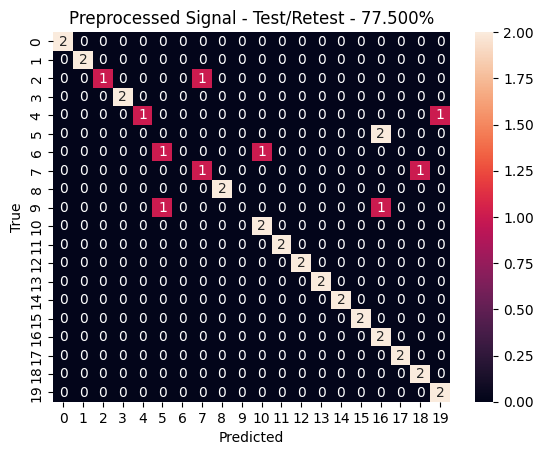

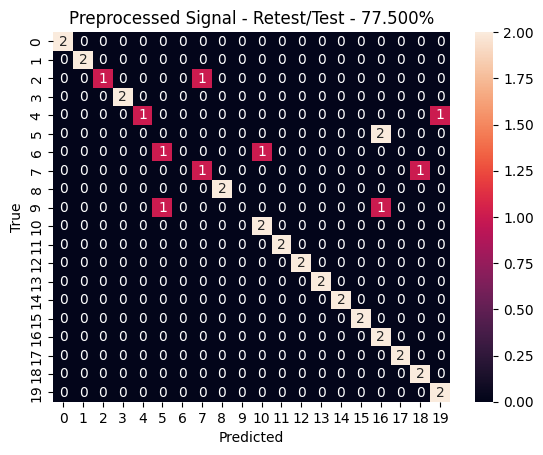

In [3]:
tr_exp = 'cnn1d_preprocessed_test_retest'
rt_exp = 'cnn1d_preprocessed_retest_test'
# Specify the path to the saved h5 model file
preprocessed_test_retest_path = f'{PATH}/{tr_exp}.h5'
preprocessed_retest_test_path = f'{PATH}/{rt_exp}.h5'

# Load the model
preprocessed_test_retest_model = load_model(preprocessed_test_retest_path)
preprocessed_retest_test_model = load_model(preprocessed_retest_test_path)

print(preprocessed_retest_test_model.summary())

NPY_DATA_DIR = "npy_datasets"

# Load the dataset
test_dataset = np.load(
    f"{NPY_DATA_DIR}/test_preprocessed.npy", allow_pickle=True
)
retest_dataset = np.load(
    f"{NPY_DATA_DIR}/retest_preprocessed.npy", allow_pickle=True
)

X_test, y_test = prepare_data(test_dataset)
X_retest, y_retest = prepare_data(retest_dataset)

print(X_test.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_retest = X_retest.reshape(X_retest.shape[0], X_retest.shape[1], 1)

_, test_acc = preprocessed_test_retest_model.evaluate(X_retest, y_retest, verbose=0)
_, retest_acc = preprocessed_retest_test_model.evaluate(X_test, y_test, verbose=0)

test_acc = test_acc * 100
retest_acc = retest_acc * 100

tr_metrics.append(test_acc)
rt_metrics.append(retest_acc)
combined_metrics.append(f1_metric(test_acc, retest_acc))
tr_names.append('preprocess')

print('test_acc', test_acc)
print('retest_acc', retest_acc)

test_pred = preprocessed_test_retest_model.predict(X_retest)
test_pred_classes = np.argmax(test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
test_confusion_mtx = confusion_matrix(y_test, test_pred_classes)

retest_pred = preprocessed_retest_test_model.predict(X_test)
retest_pred_classes = np.argmax(retest_pred, axis=1)
y_retest = np.argmax(y_retest, axis=1)
retest_confusion_mtx = confusion_matrix(y_retest, retest_pred_classes)

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Preprocessed Signal - Test/Retest - {test_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_preprocessed_test_retest.png')
plt.show()

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Preprocessed Signal - Retest/Test - {retest_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_preprocessed_retest_test.png')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9606, 8)           264       
_________________________________________________________________
activation_3 (Activation)    (None, 9606, 8)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4803, 8)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4803, 16)          4112      
_________________________________________________________________
activation_4 (Activation)    (None, 4803, 16)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2401, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38416)            

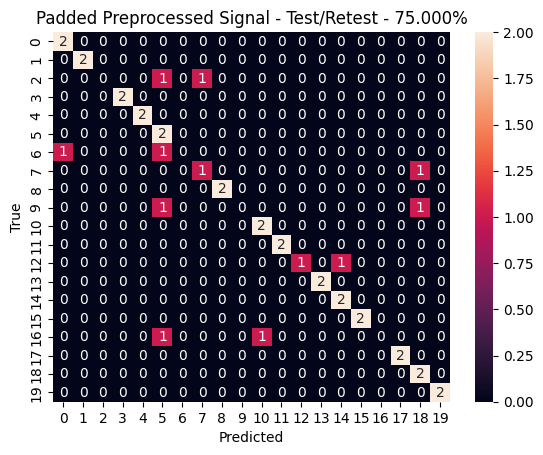

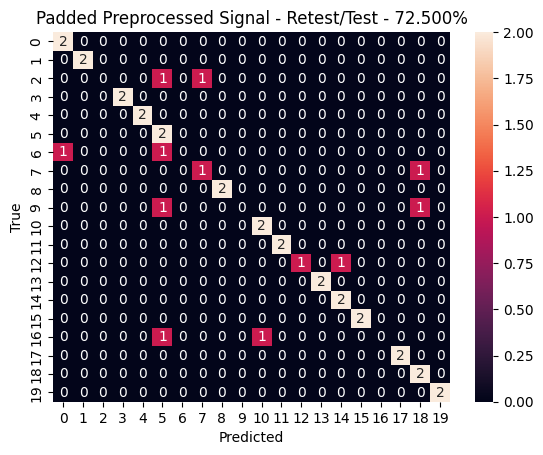

In [4]:
tr_exp = 'cnn1d_preprocessed_padded_test_retest'
rt_exp = 'cnn1d_preprocessed_padded_retest_test'
# Specify the path to the saved h5 model file
preprocessed_padded_test_retest_path = f'{PATH}/{tr_exp}.h5'
preprocessed_padded_retest_test_path = f'{PATH}/{rt_exp}.h5'

# Load the model
preprocessed_padded_test_retest_model = load_model(preprocessed_padded_test_retest_path)
preprocessed_padded_retest_test_model = load_model(preprocessed_padded_retest_test_path)

print(preprocessed_padded_retest_test_model.summary())

NPY_DATA_DIR = "npy_datasets"

# Load the dataset
test_dataset = np.load(
    f"{NPY_DATA_DIR}/test_preprocessed_padded.npy", allow_pickle=True
)
retest_dataset = np.load(
    f"{NPY_DATA_DIR}/retest_preprocessed_padded.npy", allow_pickle=True
)

X_test, y_test = prepare_data(test_dataset)
X_retest, y_retest = prepare_data(retest_dataset)

print(X_test.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_retest = X_retest.reshape(X_retest.shape[0], X_retest.shape[1], 1)

_, test_acc = preprocessed_padded_test_retest_model.evaluate(X_retest, y_retest, verbose=0)
_, retest_acc = preprocessed_padded_retest_test_model.evaluate(X_test, y_test, verbose=0)

test_acc = test_acc * 100
retest_acc = retest_acc * 100

tr_metrics.append(test_acc)
rt_metrics.append(retest_acc)
combined_metrics.append(f1_metric(test_acc, retest_acc))
tr_names.append('preprocess_pad')

print('test_acc', test_acc)
print('retest_acc', retest_acc)

test_pred = preprocessed_padded_test_retest_model.predict(X_retest)
test_pred_classes = np.argmax(test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
test_confusion_mtx = confusion_matrix(y_test, test_pred_classes)

retest_pred = preprocessed_padded_retest_test_model.predict(X_test)
retest_pred_classes = np.argmax(retest_pred, axis=1)
y_retest = np.argmax(y_retest, axis=1)
retest_confusion_mtx = confusion_matrix(y_retest, retest_pred_classes)

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Padded Preprocessed Signal - Test/Retest - {test_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_preprocessed_padded_test_retest.png')
plt.show()

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Padded Preprocessed Signal - Retest/Test - {retest_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_preprocessed_padded_retest_test.png')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1300, 8)           264       
_________________________________________________________________
activation_3 (Activation)    (None, 1300, 8)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 650, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 650, 16)           4112      
_________________________________________________________________
activation_4 (Activation)    (None, 650, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 325, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5200)             

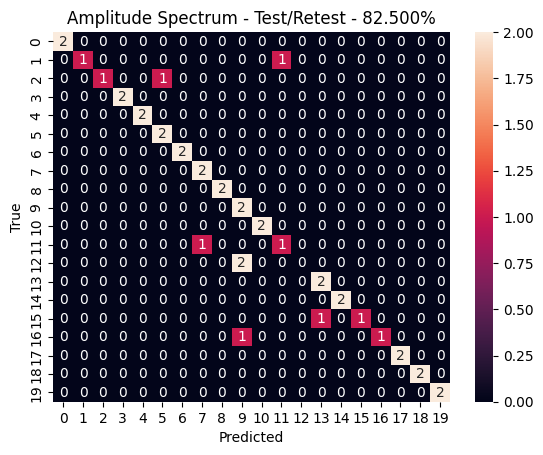

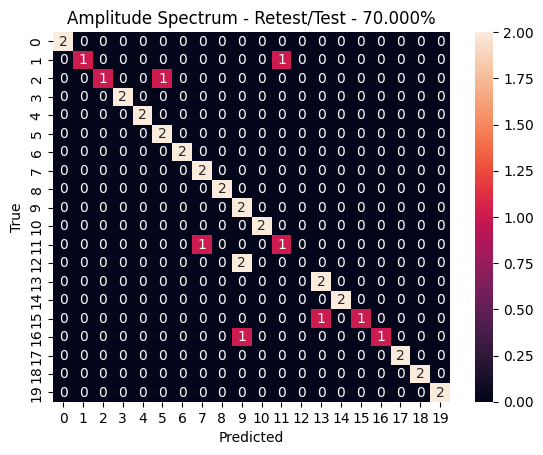

In [5]:
tr_exp = 'cnn1d_ampspectra_test_retest'
rt_exp = 'cnn1d_ampspectra_retest_test'
# Specify the path to the saved h5 model file
ampspectra_test_retest_path = f'{PATH}/{tr_exp}.h5'
ampspectra_retest_test_path = f'{PATH}/{rt_exp}.h5'

# Load the model
ampspectra_test_retest_model = load_model(ampspectra_test_retest_path)
ampspectra_retest_test_model = load_model(ampspectra_retest_test_path)

print(ampspectra_retest_test_model.summary())

NPY_DATA_DIR = "npy_datasets"

# Load the dataset
test_dataset = np.load(
    f"{NPY_DATA_DIR}/test_amp.npy", allow_pickle=True
)
retest_dataset = np.load(
    f"{NPY_DATA_DIR}/retest_amp.npy", allow_pickle=True
)

X_test, y_test = prepare_data(test_dataset)
X_retest, y_retest = prepare_data(retest_dataset)

print(X_test.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_retest = X_retest.reshape(X_retest.shape[0], X_retest.shape[1], 1)

X_test = normalize_min_max_v2(X_test, 0, 1)
X_retest = normalize_min_max_v2(X_retest, 0, 1)

_, test_acc = ampspectra_test_retest_model.evaluate(X_retest, y_retest, verbose=0)
_, retest_acc = ampspectra_retest_test_model.evaluate(X_test, y_test, verbose=0)

test_acc = test_acc * 100
retest_acc = retest_acc * 100

tr_metrics.append(test_acc)
rt_metrics.append(retest_acc)
combined_metrics.append(f1_metric(test_acc, retest_acc))
tr_names.append('amp_spectra')

print('test_acc', test_acc)
print('retest_acc', retest_acc)

test_pred = ampspectra_test_retest_model.predict(X_retest)
test_pred_classes = np.argmax(test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
test_confusion_mtx = confusion_matrix(y_test, test_pred_classes)

retest_pred = ampspectra_retest_test_model.predict(X_test)
retest_pred_classes = np.argmax(retest_pred, axis=1)
y_retest = np.argmax(y_retest, axis=1)
retest_confusion_mtx = confusion_matrix(y_retest, retest_pred_classes)

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Amplitude Spectrum - Test/Retest - {test_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_ampspectra_test_retest.png')
plt.show()

sns.heatmap(test_confusion_mtx, annot=True, fmt='d')
plt.title(f'Amplitude Spectrum - Retest/Test - {retest_acc:.3f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/cnn1d_models/plots/cnn1d_ampspectra_retest_test.png')
plt.show()

[89.99999761581421, 77.49999761581421, 75.0, 82.4999988079071]
[85.00000238418579, 77.49999761581421, 72.50000238418579, 69.9999988079071]


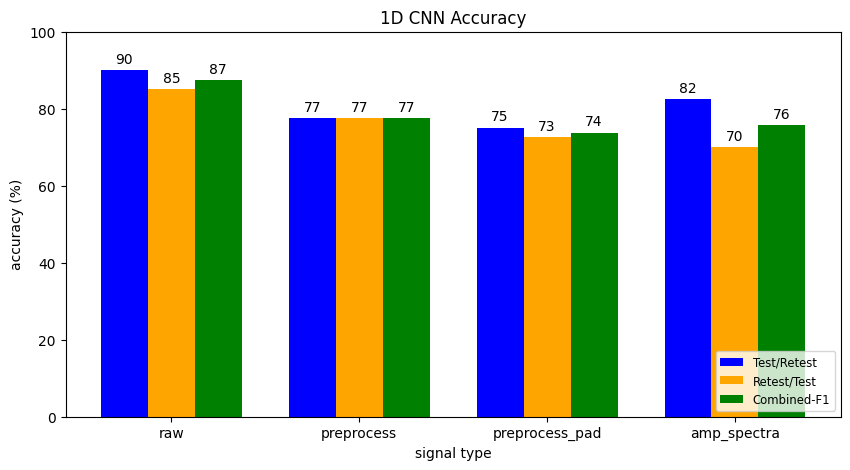

: 

In [6]:
print(tr_metrics)
print(rt_metrics)

n = len(tr_metrics)  # Number of data pairs
ind = np.arange(n)  # The x locations for the groups
width = 0.25        # Width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
x_bars = ax.bar(ind - width, tr_metrics, width, label='Test/Retest', color='blue')
y_bars = ax.bar(ind, rt_metrics, width, label='Retest/Test', color='orange')
z_bars = ax.bar(ind + width, combined_metrics, width, label='Combined-F1', color='green')

for bar in x_bars + y_bars + z_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}',  # Adjust format as needed
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset
                textcoords='offset points',
                ha='center', va='bottom')

ax.set_xlabel('signal type')
ax.set_ylabel('accuracy (%)')
ax.set_title('1D CNN Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(tr_names)
ax.set_ylim([0, 100])
ax.legend(fontsize='small', loc='lower right')

plt.savefig(f'{PATH}/plots/cnn1d_accuracy.png')
plt.show()